# Car Part Detection

Problem: Non-car savy people can easily get scammed by garages when they cannot identify the part that is causing the problem. 

Creating an application that can identify a part for a car owner allows them to research more into the part and what may be causing an issue.

In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# CHECKING IF GOOGLE COLAB ENVIRONMENT OR LOCAL

GOOGLE_COLAB = False
DATASET_ROOT = 'datasets/car_part/'

try:
    import google_colab
    GOOGLE_COLAB = True
    DATASET_ROOT = '/content/car_part/'
except ImportError:
    GOOGLE_COLAB = False
    DATASET_ROOT = 'datasets/car_part/'

## Loading Data

In [211]:
df = pd.read_csv(DATASET_ROOT + "train_car.csv")
df

,class index,filepaths,labels,data set
0,0,train/AIR COMPRESSOR/001.jpg,AIR COMPRESSOR,train
1,0,train/AIR COMPRESSOR/002.jpg,AIR COMPRESSOR,train
2,0,train/AIR COMPRESSOR/003.jpg,AIR COMPRESSOR,train
3,0,train/AIR COMPRESSOR/004.jpg,AIR COMPRESSOR,train
4,0,train/AIR COMPRESSOR/005.jpg,AIR COMPRESSOR,train
...,...,...,...,...
8734,49,train/WINDOW REGULATOR/175.jpg,WINDOW REGULATOR,train
8735,49,train/WINDOW REGULATOR/176.jpg,WINDOW REGULATOR,train
8736,49,train/WINDOW REGULATOR/177.jpg,WINDOW REGULATOR,train
8737,49,train/WINDOW REGULATOR/178.jpg,WINDOW REGULATOR,train


In [212]:
# add DATASET_ROOT + /car_part/ to filepaths
df['filepaths'] = df['filepaths'].apply(lambda path: DATASET_ROOT + path)
df

,class index,filepaths,labels,data set
0,0,datasets/car_part/train/AIR COMPRESSOR/001.jpg,AIR COMPRESSOR,train
1,0,datasets/car_part/train/AIR COMPRESSOR/002.jpg,AIR COMPRESSOR,train
2,0,datasets/car_part/train/AIR COMPRESSOR/003.jpg,AIR COMPRESSOR,train
3,0,datasets/car_part/train/AIR COMPRESSOR/004.jpg,AIR COMPRESSOR,train
4,0,datasets/car_part/train/AIR COMPRESSOR/005.jpg,AIR COMPRESSOR,train
...,...,...,...,...
8734,49,datasets/car_part/train/WINDOW REGULATOR/175.jpg,WINDOW REGULATOR,train
8735,49,datasets/car_part/train/WINDOW REGULATOR/176.jpg,WINDOW REGULATOR,train
8736,49,datasets/car_part/train/WINDOW REGULATOR/177.jpg,WINDOW REGULATOR,train
8737,49,datasets/car_part/train/WINDOW REGULATOR/178.jpg,WINDOW REGULATOR,train


## EDA

### Class Balance

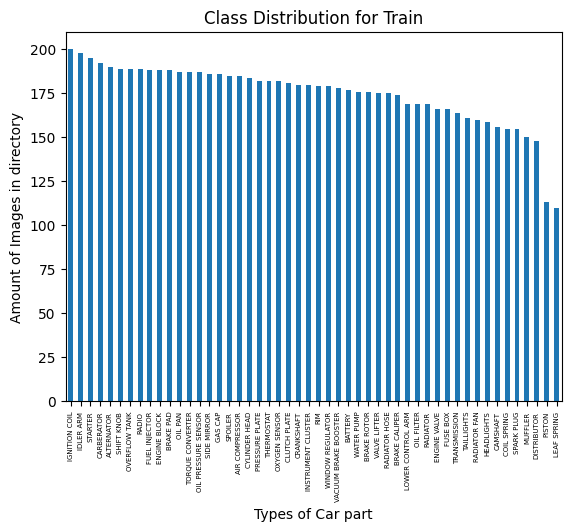

In [213]:
df['labels'].value_counts().plot(kind="bar")

plt.tick_params(axis='x', which='major', labelsize=5)
plt.xlabel("Types of Car part")
plt.ylabel("Amount of Images in directory")
plt.title("Class Distribution for Train")

plt.show()

This shows a somewhat even distribution between classes is somewhat even. There might be some bias towards the classes with the highest images 

### Image Size

In [10]:
from PIL import Image
from tqdm import tqdm

In [11]:
def get_dim(file):
    """
        Returns the image height & width
    """
    img = Image.open(file)
    arr = np.array(img)
    dims = arr.shape
    return (dims[0], dims[1])

In [12]:
# create new df for plotting image dimensions
filepaths = df['filepaths']

dims = []
for path in tqdm(filepaths):
    dims.append(get_dim(path))

100%|██████████| 8739/8739 [00:09<00:00, 940.76it/s] 


In [13]:
res_df = pd.DataFrame(dims, columns=['height', 'width'])
res_df

,height,width
0,224,224
1,224,224
2,224,224
3,224,224
4,224,224
...,...,...
8734,224,224
8735,224,224
8736,224,224
8737,224,224


Text(0.5, 1.0, 'Image Resolution')

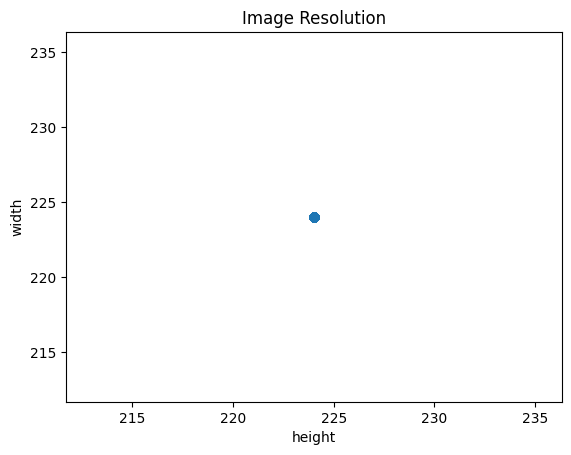

In [14]:
# plot into scatter plot
fig, axes = plt.subplots()

axes.scatter(x=res_df['width'], y=res_df['height'])
axes.set_xlabel("height")
axes.set_ylabel("width")

axes.set_title("Image Resolution")

All images are uniform resolution. No resizing needed

### Image Sampling

In [170]:
import random
import cv2

In [192]:
# generate 4 random image index
img_inds = []
for i in range(0,5):
    img_inds.append(random.randint(0, len(df)))

img_inds

[4449, 860, 5133, 6439, 7622]

(-0.5, 223.5, 223.5, -0.5)

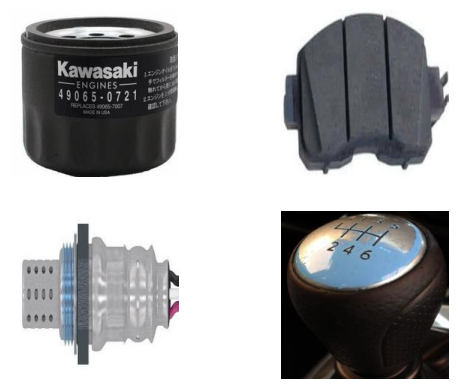

In [193]:
fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(cv2.imread(df.loc[img_inds[0]]['filepaths']))
axes[0, 1].imshow(cv2.imread(df.loc[img_inds[1]]['filepaths']))
axes[1, 0].imshow(cv2.imread(df.loc[img_inds[2]]['filepaths']))
axes[1, 1].imshow(cv2.imread(df.loc[img_inds[3]]['filepaths']))

axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

## Attempt 1: No Processing

### Building model

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [16]:
def build_model():
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [274]:
model = build_model()

In [273]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_658 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_658[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_658      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_659 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_658[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_659[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_659      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_660 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_659[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_660[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_660      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 54, 54,    │          0 │ activation_660[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_661 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_28… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_661[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_661      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_662 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_661[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_662[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_662      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 179,246,008 (683.77 MB)

 Trainable params: 52,481,074 (200.20 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 104,962,150 (400.40 MB)

In [240]:
# callback function to stop training when target acc reached
class myCallbacK(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('acc'):
            if log.get('acc') > 0.955:
                self.model.stop_training = True

### Generating Datasets

This does not contain any image augmentation.

In [235]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [236]:
# Without any augmentation
image_size = (224, 224)
batch_size = 32

# Training Set
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_ds = train_gen.flow_from_directory(
    DATASET_ROOT + 'train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation Set
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = validation_gen.flow_from_directory(
    DATASET_ROOT + 'valid',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8739 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


### Training Model

In [237]:
model = build_model()

In [241]:
history = model.fit(
    train_ds, 
    epochs=20, 
    validation_data=val_ds, 
    callbacks=myCallbacK()
)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 235s 858ms/step - accuracy: 0.7642 - loss: 0.8472 - val_accuracy: 0.8000 - val_loss: 0.7809
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 847ms/step - accuracy: 0.8321 - loss: 0.5661 - val_accuracy: 0.7400 - val_loss: 1.1639
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 845ms/step - accuracy: 0.8502 - loss: 0.4944 - val_accuracy: 0.8360 - val_loss: 0.8659
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 233s 849ms/step - accuracy: 0.8859 - loss: 0.3721 - val_accuracy: 0.8120 - val_loss: 0.7981
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 221s 805ms/step - accuracy: 0.8907 - loss: 0.3585 - val_accuracy: 0.7920 - val_loss: 0.8649
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 220s 803ms/step - accuracy: 0.9071 - loss: 0.2996 - val_accuracy: 0.8200 - val_loss: 0.9133
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 222s 809ms/step - accuracy: 0.9115 - loss: 0.2788 - val_accuracy: 0.8040 - val_loss: 0.9661
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 219s 800ms/step - accuracy: 0.8995 -

In [242]:
model.save("model.h5")

### Model Evaluation

In [248]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.763588,0.839265,0.800,0.780915,0
1,0.820918,0.613892,0.740,1.163917,1
2,0.859824,0.459183,0.836,0.865915,2
3,0.883511,0.382846,0.812,0.798078,3
4,0.897128,0.340089,0.792,0.864919,4
5,0.907312,0.307810,0.820,0.913320,5
6,0.906397,0.304270,0.804,0.966111,6
7,0.887401,0.398714,0.832,1.147498,7
8,0.877331,0.461974,0.780,1.123178,8
9,0.892093,0.401479,0.792,1.307345,9


In [ ]:
import matplotlib.pyplot as plt

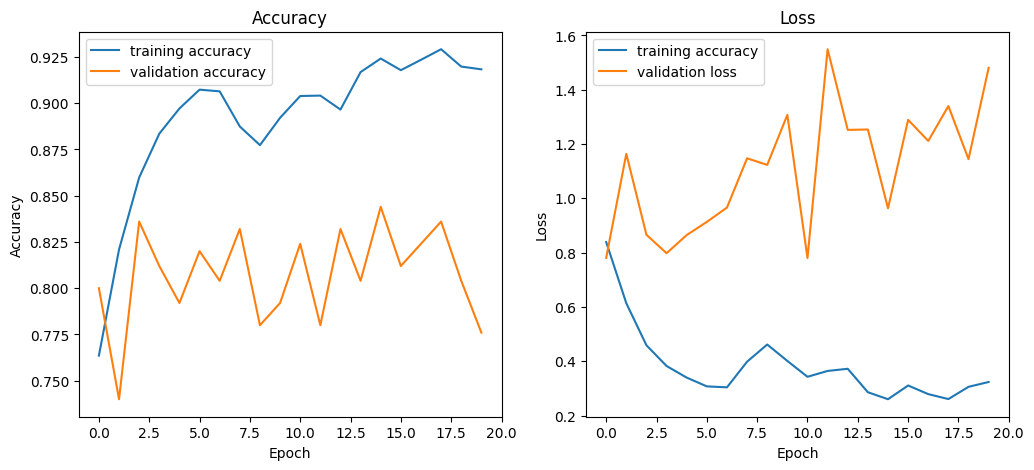

In [272]:
# accuracy plot
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(hist['epoch'], hist['accuracy'], label='training accuracy')
axes[0].plot(hist['epoch'], hist['val_accuracy'], label='validation accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlim(-1, 20)
axes[0].legend()

axes[1].plot(hist['epoch'], hist['loss'], label='training accuracy')
axes[1].plot(hist['epoch'], hist['val_loss'], label='validation loss')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].set_xlim(-1, 20)
axes[1].legend()

plt.show()

In [244]:
# Retrieve the history of the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Retrieve the last entry in the training and validation accuracy lists
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")


Final Training Accuracy: 91.83%
Final Validation Accuracy: 77.60%


In [ ]:
# This approach has lead to overfitting.

The attempt lead to overfitting. The cause for it is unknown. 

It could be due to too much data, complex model architecture or other things.

## Attempt 2: Data Split & Class Reduction

### Building Model

In [214]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [215]:
def build_model(output_classes=50):
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(output_classes, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [95]:
# callback function to stop training when target acc reached
class myCallbacK(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('acc'):
            if log.get('acc') > 0.955:
                self.model.stop_training = True

### Generating Datasets

In [216]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split

In [217]:
image_size = (224, 224)
batch_size=32

# selecting only the top 10 classes
top_10 = [
    "IGNITION COIL",
    "IDLER ARM",
    "STARTER",
    "CARBERATOR",
    "ALTERNATOR",
    "SHIFT KNOB",
    "OVERFLOW TANK",
    "RADIO",
    "FUEL INJECTOR",
    "ENGINE BLOCK"
]

In [218]:
# filter df to only include the top 10 classes

filtered_df = df[df['labels'].isin(top_10)]
filtered_df

,class index,filepaths,labels,data set
185,1,datasets/car_part/train/ALTERNATOR/001.jpg,ALTERNATOR,train
186,1,datasets/car_part/train/ALTERNATOR/002.jpg,ALTERNATOR,train
187,1,datasets/car_part/train/ALTERNATOR/003.jpg,ALTERNATOR,train
188,1,datasets/car_part/train/ALTERNATOR/004.jpg,ALTERNATOR,train
189,1,datasets/car_part/train/ALTERNATOR/005.jpg,ALTERNATOR,train
...,...,...,...,...
7332,41,datasets/car_part/train/STARTER/191.jpg,STARTER,train
7333,41,datasets/car_part/train/STARTER/192.jpg,STARTER,train
7334,41,datasets/car_part/train/STARTER/193.jpg,STARTER,train
7335,41,datasets/car_part/train/STARTER/194.jpg,STARTER,train


In [219]:
# split dataframe into 70/30 for train&val/test
train_val_df, test_df = train_test_split(
    filtered_df, test_size=0.3, random_state=1
)

In [220]:
# split train%val into 70:30 for train/val
train_df, val_df = train_test_split(
    train_val_df, test_size=0.3, random_state=1
)
train_df

,class index,filepaths,labels,data set
5048,28,datasets/car_part/train/OVERFLOW TANK/160.jpg,OVERFLOW TANK,train
4912,28,datasets/car_part/train/OVERFLOW TANK/024.jpg,OVERFLOW TANK,train
6427,37,datasets/car_part/train/SHIFT KNOB/001.jpg,SHIFT KNOB,train
338,1,datasets/car_part/train/ALTERNATOR/154.jpg,ALTERNATOR,train
347,1,datasets/car_part/train/ALTERNATOR/163.jpg,ALTERNATOR,train
...,...,...,...,...
6231,35,datasets/car_part/train/RADIO/173.jpg,RADIO,train
2301,13,datasets/car_part/train/ENGINE BLOCK/016.jpg,ENGINE BLOCK,train
240,1,datasets/car_part/train/ALTERNATOR/056.jpg,ALTERNATOR,train
6127,35,datasets/car_part/train/RADIO/069.jpg,RADIO,train


In [221]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

# convert dataframes into datasets
train_ds = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1
)

val_ds = train_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1
)

test_ds = train_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1,
    shuffle=False
)

Found 939 validated image filenames belonging to 10 classes.


Found 403 validated image filenames belonging to 10 classes.
Found 576 validated image filenames belonging to 10 classes.


### Training Model

In [222]:
model = build_model(output_classes=10)

In [223]:
history = model.fit(
    train_ds, 
    epochs=20, 
    validation_data=val_ds, 
    callbacks=myCallbacK()
)

Epoch 1/20


f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3191 - loss: 55.9240 - val_accuracy: 0.8437 - val_loss: 2.1974
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8782 - loss: 1.8523 - val_accuracy: 0.8412 - val_loss: 1.6070
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9422 - loss: 0.4383 - val_accuracy: 0.9057 - val_loss: 0.9303
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9780 - loss: 0.1498 - val_accuracy: 0.8834 - val_loss: 1.1968
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9847 - loss: 0.0910 - val_accuracy: 0.9181 - val_loss: 0.5020
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9847 - loss: 0.0665 - val_accuracy: 0.9082 - val_loss: 0.7896
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9851 - loss: 0.0891 - val_accuracy: 0.9082 - val_loss: 0.6962
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9879 - loss: 0.0497 - val_accuracy: 0.9355 - val_loss: 0.5811
Ep

### Model Evaluation

In [224]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.496273,34.280647,0.843672,2.197405,0
1,0.888179,1.495264,0.841191,1.606970,1
2,0.951012,0.365307,0.905707,0.930297,2
3,0.976571,0.184201,0.883375,1.196841,3
4,0.984026,0.089864,0.918114,0.502036,4
5,0.984026,0.071077,0.908189,0.789550,5
6,0.986156,0.090950,0.908189,0.696216,6
7,0.988285,0.052456,0.935484,0.581140,7
8,1.000000,0.001369,0.930521,0.525499,8
9,0.996805,0.005745,0.915633,0.754404,9


In [225]:
import matplotlib.pyplot as plt

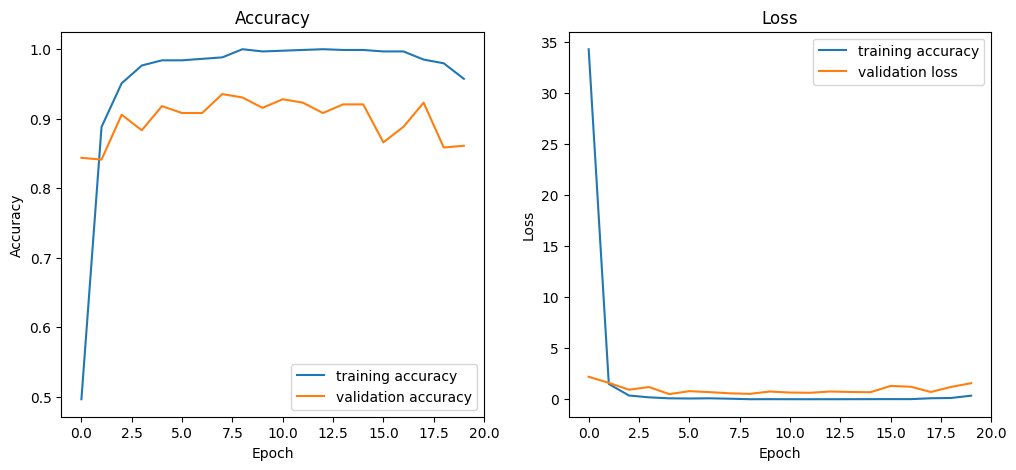

In [226]:
# accuracy plot
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(hist['epoch'], hist['accuracy'], label='training accuracy')
axes[0].plot(hist['epoch'], hist['val_accuracy'], label='validation accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlim(-1, 20)
axes[0].legend()

axes[1].plot(hist['epoch'], hist['loss'], label='training accuracy')
axes[1].plot(hist['epoch'], hist['val_loss'], label='validation loss')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].set_xlim(-1, 20)
axes[1].legend()

plt.show()

In [227]:
# Retrieve the history of the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Retrieve the last entry in the training and validation accuracy lists
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

Final Training Accuracy: 95.74%
Final Validation Accuracy: 86.10%


In [231]:
# load image to numpy array
from PIL import Image
img = Image.open("F:\Code Repos\CSCI316-Proj2\datasets\car_part\\test\\FUEL INJECTOR\\1.jpg")
img_arr = np.array(img)

In [232]:
# preprocess
preprocessed_image = preprocess_input(test_ds)
preprocessed_image.shape


(224, 224, 3)

In [234]:
prediction = model.predict(test_ds)

f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step


In [236]:
test_df

,class index,filepaths,labels,data set
233,1,datasets/car_part/train/ALTERNATOR/049.jpg,ALTERNATOR,train
3695,20,datasets/car_part/train/IGNITION COIL/159.jpg,IGNITION COIL,train
4943,28,datasets/car_part/train/OVERFLOW TANK/055.jpg,OVERFLOW TANK,train
1250,7,datasets/car_part/train/CARBERATOR/005.jpg,CARBERATOR,train
1424,7,datasets/car_part/train/CARBERATOR/179.jpg,CARBERATOR,train
...,...,...,...,...
186,1,datasets/car_part/train/ALTERNATOR/002.jpg,ALTERNATOR,train
2723,15,datasets/car_part/train/FUEL INJECTOR/084.jpg,FUEL INJECTOR,train
6586,37,datasets/car_part/train/SHIFT KNOB/161.jpg,SHIFT KNOB,train
327,1,datasets/car_part/train/ALTERNATOR/143.jpg,ALTERNATOR,train


In [235]:
prediction[0]

array([9.9999499e-01, 5.9929323e-07, 1.2919738e-15, 1.5020221e-10,
       6.0061774e-22, 1.1283511e-14, 4.4257536e-06, 1.9709848e-17,
       1.3392643e-08, 9.9416281e-11], dtype=float32)

In [241]:
np.argmax(prediction[0])

test_ds.class_indices

{'ALTERNATOR': 0,
 'CARBERATOR': 1,
 'ENGINE BLOCK': 2,
 'FUEL INJECTOR': 3,
 'IDLER ARM': 4,
 'IGNITION COIL': 5,
 'OVERFLOW TANK': 6,
 'RADIO': 7,
 'SHIFT KNOB': 8,
 'STARTER': 9}

In [242]:
model.save("top_10_model.h5")

With just changing the % of the data used for training and validation, the overfitting problem has been reduced and the model is able to correctly predict. This is however with only 10 classes. We increase the classes from 10 to 25 and if the acc% stays, then 40 and then 50.

If it dips, then we go back to whatever was stable last and look at other areas of improvement.

## Attempt 3: Dropout Optimization

### Building Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [251]:
def build_model(hp, output_classes=50, dropout=0.2):
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(
            hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.2)
        )(x)
    x = Dense(output_classes, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
        
    return model

### Generating Datasets

In [243]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split

In [244]:
image_size = (224, 224)
batch_size=32

In [249]:
# split data into 70/30 for train/test
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=1
)

,class index,filepaths,labels,data set
2198,12,datasets/car_part/train/DISTRIBUTOR/061.jpg,DISTRIBUTOR,train
8512,48,datasets/car_part/train/WATER PUMP/129.jpg,WATER PUMP,train
7008,40,datasets/car_part/train/SPOILER/052.jpg,SPOILER,train
2491,14,datasets/car_part/train/ENGINE VALVE/018.jpg,ENGINE VALVE,train
4553,26,datasets/car_part/train/OIL PAN/039.jpg,OIL PAN,train
...,...,...,...,...
5921,34,datasets/car_part/train/RADIATOR HOSE/038.jpg,RADIATOR HOSE,train
8649,49,datasets/car_part/train/WINDOW REGULATOR/090.jpg,WINDOW REGULATOR,train
222,1,datasets/car_part/train/ALTERNATOR/038.jpg,ALTERNATOR,train
1014,5,datasets/car_part/train/BRAKE ROTOR/101.jpg,BRAKE ROTOR,train


In [250]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

# convert dataframes into datasets
train_ds = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1
)

test_ds = train_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    class_mode='categorical',
    seed=1,
    shuffle=False
)

Found 6117 validated image filenames belonging to 50 classes.
Found 2622 validated image filenames belonging to 50 classes.


### Training Model

In [254]:
from kerastuner.tuners import RandomSearch

C:\Users\moham\AppData\Local\Temp\ipykernel_28928\2610907151.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [256]:
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hp_tuning',
    project_name='dropout_tuning'
)

In [257]:
tuner.search(train_ds,
             epochs=10)

Trial 2 Complete [00h 28m 08s]
accuracy: 0.797940194606781

Best accuracy So Far: 0.9288867115974426
Total elapsed time: 00h 57m 36s


### Model Evaluation

In [267]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# This is the best dropout rate it found between the values [0.2, 0.4, 0.6]

best_hps.get('dropout_rate')

0.2

In [291]:
for trial in tuner.oracle.trials:
    print(trial)

0
1


In [286]:
hist = pd.DataFrame(tuner.oracle.get_history())
hist['epoch'] = history.epoch
hist

AttributeError: 'RandomSearchOracle' object has no attribute 'get_history'

In [260]:
import matplotlib.pyplot as plt

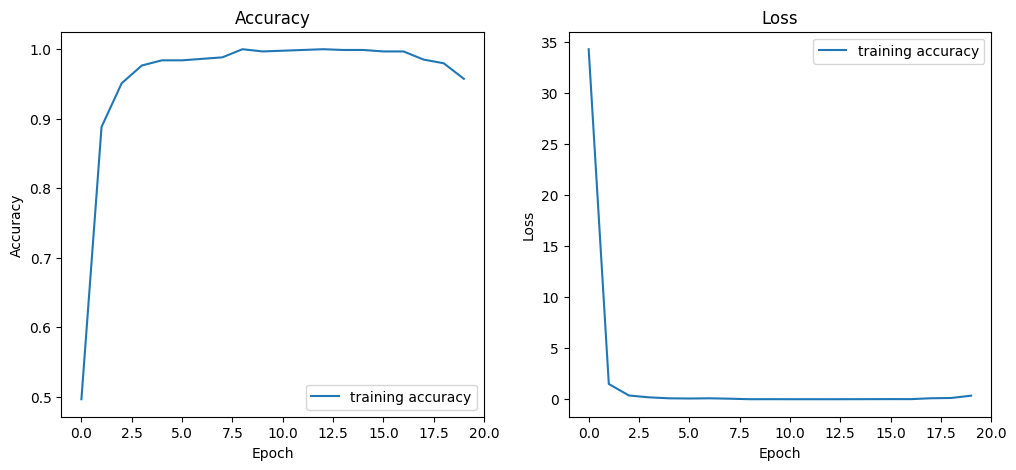

In [261]:
# accuracy plot
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(hist['epoch'], hist['accuracy'], label='training accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlim(-1, 20)
axes[0].legend()

axes[1].plot(hist['epoch'], hist['loss'], label='training accuracy')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].set_xlim(-1, 20)
axes[1].legend()

plt.show()

In [262]:
# Retrieve the history of the training and validation accuracy
training_accuracy = history.history['accuracy']

# Retrieve the last entry in the training and validation accuracy lists
final_training_accuracy = training_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")


Final Training Accuracy: 95.74%


### Prediction

In [272]:
x = test_df['filepaths']
y = test_df['labels']

(x, y)

(2198         datasets/car_part/train/DISTRIBUTOR/061.jpg
 8512          datasets/car_part/train/WATER PUMP/129.jpg
 7008             datasets/car_part/train/SPOILER/052.jpg
 2491        datasets/car_part/train/ENGINE VALVE/018.jpg
 4553             datasets/car_part/train/OIL PAN/039.jpg
                               ...                       
 5921       datasets/car_part/train/RADIATOR HOSE/038.jpg
 8649    datasets/car_part/train/WINDOW REGULATOR/090.jpg
 222           datasets/car_part/train/ALTERNATOR/038.jpg
 1014         datasets/car_part/train/BRAKE ROTOR/101.jpg
 5524      datasets/car_part/train/PRESSURE PLATE/152.jpg
 Name: filepaths, Length: 2622, dtype: object,
 2198         DISTRIBUTOR
 8512          WATER PUMP
 7008             SPOILER
 2491        ENGINE VALVE
 4553             OIL PAN
               ...       
 5921       RADIATOR HOSE
 8649    WINDOW REGULATOR
 222           ALTERNATOR
 1014         BRAKE ROTOR
 5524      PRESSURE PLATE
 Name: labels, Length: 2622, 

In [275]:
model = tuner.get_best_models()[0]

f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [321]:
model.save("hp_dropout_model.h5")

In [276]:
predictions = model.predict(test_ds)

f:\Code Repos\CSCI316-Proj2\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 566ms/step


In [292]:
class_labels = {index: label for label, index in test_ds.class_indices.items()}
class_labels

{0: 'AIR COMPRESSOR',
 1: 'ALTERNATOR',
 2: 'BATTERY',
 3: 'BRAKE CALIPER',
 4: 'BRAKE PAD',
 5: 'BRAKE ROTOR',
 6: 'CAMSHAFT',
 7: 'CARBERATOR',
 8: 'CLUTCH PLATE',
 9: 'COIL SPRING',
 10: 'CRANKSHAFT',
 11: 'CYLINDER HEAD',
 12: 'DISTRIBUTOR',
 13: 'ENGINE BLOCK',
 14: 'ENGINE VALVE',
 15: 'FUEL INJECTOR',
 16: 'FUSE BOX',
 17: 'GAS CAP',
 18: 'HEADLIGHTS',
 19: 'IDLER ARM',
 20: 'IGNITION COIL',
 21: 'INSTRUMENT CLUSTER',
 22: 'LEAF SPRING',
 23: 'LOWER CONTROL ARM',
 24: 'MUFFLER',
 25: 'OIL FILTER',
 26: 'OIL PAN',
 27: 'OIL PRESSURE SENSOR',
 28: 'OVERFLOW TANK',
 29: 'OXYGEN SENSOR',
 30: 'PISTON',
 31: 'PRESSURE PLATE',
 32: 'RADIATOR',
 33: 'RADIATOR FAN',
 34: 'RADIATOR HOSE',
 35: 'RADIO',
 36: 'RIM',
 37: 'SHIFT KNOB',
 38: 'SIDE MIRROR',
 39: 'SPARK PLUG',
 40: 'SPOILER',
 41: 'STARTER',
 42: 'TAILLIGHTS',
 43: 'THERMOSTAT',
 44: 'TORQUE CONVERTER',
 45: 'TRANSMISSION',
 46: 'VACUUM BRAKE BOOSTER',
 47: 'VALVE LIFTER',
 48: 'WATER PUMP',
 49: 'WINDOW REGULATOR'}

In [306]:
preds = []
pred_index = []
for pred in predictions:
    class_pred = np.argmax(pred)
    preds.append(class_labels[class_pred])
    pred_index.append(class_pred)
    
test_df['predicted_labels'] = preds
test_df['predicted_index'] = pred_index

test_df

,class index,filepaths,labels,predicted_labels,predicted_index
2198,12,datasets/car_part/train/DISTRIBUTOR/061.jpg,DISTRIBUTOR,DISTRIBUTOR,12
8512,48,datasets/car_part/train/WATER PUMP/129.jpg,WATER PUMP,WATER PUMP,48
7008,40,datasets/car_part/train/SPOILER/052.jpg,SPOILER,SPOILER,40
2491,14,datasets/car_part/train/ENGINE VALVE/018.jpg,ENGINE VALVE,ENGINE VALVE,14
4553,26,datasets/car_part/train/OIL PAN/039.jpg,OIL PAN,OIL PAN,26
...,...,...,...,...,...
5921,34,datasets/car_part/train/RADIATOR HOSE/038.jpg,RADIATOR HOSE,CARBERATOR,7
8649,49,datasets/car_part/train/WINDOW REGULATOR/090.jpg,WINDOW REGULATOR,WINDOW REGULATOR,49
222,1,datasets/car_part/train/ALTERNATOR/038.jpg,ALTERNATOR,ALTERNATOR,1
1014,5,datasets/car_part/train/BRAKE ROTOR/101.jpg,BRAKE ROTOR,BRAKE ROTOR,5


In [308]:
test_df[test_df['labels'] != test_df['predicted_labels']]

,class index,filepaths,labels,predicted_labels,predicted_index
4514,25,datasets/car_part/train/OIL FILTER/169.jpg,OIL FILTER,GAS CAP,17
7894,45,datasets/car_part/train/TRANSMISSION/028.jpg,TRANSMISSION,VACUUM BRAKE BOOSTER,46
6995,40,datasets/car_part/train/SPOILER/039.jpg,SPOILER,TAILLIGHTS,42
5073,28,datasets/car_part/train/OVERFLOW TANK/185.jpg,OVERFLOW TANK,AIR COMPRESSOR,0
3675,20,datasets/car_part/train/IGNITION COIL/139.jpg,IGNITION COIL,DISTRIBUTOR,12
...,...,...,...,...,...
197,1,datasets/car_part/train/ALTERNATOR/013.jpg,ALTERNATOR,DISTRIBUTOR,12
4636,26,datasets/car_part/train/OIL PAN/122.jpg,OIL PAN,SHIFT KNOB,37
7518,43,datasets/car_part/train/THERMOSTAT/021.jpg,THERMOSTAT,VACUUM BRAKE BOOSTER,46
7670,43,datasets/car_part/train/THERMOSTAT/173.jpg,THERMOSTAT,DISTRIBUTOR,12


In [318]:
from sklearn.metrics import classification_report
from sklearn.metrics import multi_classification_report

In [314]:
rep = classification_report(
    y_true=test_df['labels'],
    y_pred=test_df['predicted_labels']
)

print(rep)

                      precision    recall  f1-score   support

      AIR COMPRESSOR       0.85      0.71      0.77        48
          ALTERNATOR       0.98      0.85      0.91        54
             BATTERY       0.98      0.93      0.96        46
       BRAKE CALIPER       0.74      0.78      0.76        58
           BRAKE PAD       1.00      0.65      0.78        48
         BRAKE ROTOR       0.86      0.90      0.88        40
            CAMSHAFT       0.84      0.72      0.78        53
          CARBERATOR       0.60      0.97      0.74        58
        CLUTCH PLATE       0.98      1.00      0.99        53
         COIL SPRING       1.00      0.93      0.96        54
          CRANKSHAFT       0.91      0.70      0.79        46
       CYLINDER HEAD       1.00      0.57      0.73        56
         DISTRIBUTOR       0.46      0.68      0.55        44
        ENGINE BLOCK       0.65      0.91      0.76        64
        ENGINE VALVE       0.98      0.96      0.97        47
       

In [351]:
cm = multilabel_confusion_matrix(
    y_true=test_df['labels'],
    y_pred=test_df['predicted_labels'],
    labels=test_df['labels'].unique()
)

print(cm)

[[[2543   35]
  [  14   30]]

 [[2562   22]
  [  11   27]]

 [[2559   11]
  [   5   47]]

 [[2574    1]
  [   2   45]]

 [[2570    2]
  [  24   26]]

 [[2565   10]
  [  18   29]]

 [[2562    4]
  [  17   39]]

 [[2544   26]
  [   6   46]]

 [[2546   16]
  [   4   56]]

 [[2558   11]
  [   8   45]]

 [[2573    3]
  [  14   32]]

 [[2562    7]
  [  15   38]]

 [[2575    1]
  [   3   43]]

 [[2560    6]
  [   6   50]]

 [[2527   31]
  [   6   58]]

 [[2552    7]
  [  13   50]]

 [[2563   10]
  [   9   40]]

 [[2578   11]
  [   5   28]]

 [[2548    5]
  [  23   46]]

 [[2563    5]
  [  17   37]]

 [[2568    0]
  [   4   50]]

 [[2549   12]
  [  17   44]]

 [[2554    5]
  [  26   37]]

 [[2537   34]
  [  23   28]]

 [[2574    0]
  [  17   31]]

 [[2570    5]
  [  25   22]]

 [[2564    2]
  [   3   53]]

 [[2560    8]
  [  12   42]]

 [[2566    0]
  [  24   32]]

 [[2568    6]
  [  14   34]]

 [[2574    2]
  [   2   44]]

 [[2542   21]
  [   2   57]]

 [[2561    7]
  [   1   53]]

 [[2558   